In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
%matplotlib inline

pd.set_option("display.max_columns", 100)

# Predicting USA Election 2016

Let's see what we can predict about today's vote!

First, we need an overview of how the system works. Each state has a weighting which is based to some extent on its population size, this is called the Electoral College. There are 538 Electoral College votes in total, and whomever wins the popular vote in a state gets all the Electoral College votes for that state - with two exceptions, Maine and Nebraska. These two states have a Congressional District system that means that the winner of each Congressional District (2 for Maine and 3 for Nebraska) gets 1 vote for each and then 2 extra votes for whomever won the state overall (so 4 total Electoral College votes for Maine and 5 for Nebraska). Additionally Washington DC has 3 Electoral College votes though it is not a state. 

It takes 270 votes to win, and if any candidate fails to reach this then there would have to be a House of Representatives vote to decide with each state having one vote (this has happened three times: in 1800, 1824, and 1876). As you no doubt remember, this system means it is also possible to win having lost the nationwide popular vote as George W Bush did in 2000. We will hence go for a state by state model and not consider the nationwide popularity of each candidate.

In [2]:
# You can get some data on the electoral college votes here
# This gives a weighting to each state's popular vote

electoral_college=pd.read_csv("https://raw.githubusercontent.com/chris-taylor/USElection/master/data/electoral-college-votes.csv", header=None)
electoral_college.columns=["state", "electoral_votes"]

In [3]:
# You can get the latest polling data from 538 here

polling=pd.read_csv("http://projects.fivethirtyeight.com/general-model/president_general_polls_2016.csv")

In [5]:
# This polling data includes national polls but let's just look at the state data

polling2=polling.loc[~polling["state"].str.contains("U.S."),:]
polling2.head()

cycle     branch        type                        matchup forecastdate  \
8    2016  President  polls-plus  Clinton vs. Trump vs. Johnson      11/8/16   
13   2016  President  polls-plus  Clinton vs. Trump vs. Johnson      11/8/16   
15   2016  President  polls-plus  Clinton vs. Trump vs. Johnson      11/8/16   
17   2016  President  polls-plus  Clinton vs. Trump vs. Johnson      11/8/16   
18   2016  President  polls-plus  Clinton vs. Trump vs. Johnson      11/8/16   

             state   startdate     enddate               pollster grade  \
8       New Mexico   11/6/2016   11/6/2016               Zia Poll   NaN   
13        Virginia   11/3/2016   11/4/2016  Public Policy Polling    B+   
15            Iowa   11/1/2016   11/4/2016       Selzer & Company    A+   
17       Wisconsin  10/26/2016  10/31/2016   Marquette University     A   
18  North Carolina   11/4/2016   11/6/2016          Siena College     A   

    samplesize population   poll_wt  rawpoll_clinton  rawpoll_trump  \
8       8439.0         lv  4.609492             46.0           44.0   
13      1238.0         lv  3.923524             48.0           43.0   
15       800.0         lv  3.842234             39.0           46.0   
17      1255.0         lv  3.789957             46.0           40.0   
18       800.0         lv  3.774139             44.0           44.0   

    rawpoll_johnson  rawpoll_mcmullin  adjpoll_clinton  adjpoll_trump  \
8               6.0               NaN         44.89859       41.69639   
13              1.0               NaN         47.51307       42.33414   
15              6.0               NaN         39.48663       45.53610   
17              4.0               NaN         46.17167       40.96359   
18              3.0               NaN         44.26522       45.03691   

    adjpoll_johnson  adjpoll_mcmullin multiversions  \
8          8.038537               NaN           NaN   
13         2.137212               NaN           NaN   
15         5.956656               NaN           NaN   
17         2.739735               NaN           NaN   
18         2.221380               NaN           NaN   

                                                  url  poll_id  question_id  \
8   http://projects.fivethirtyeight.com.s3.amazona...    48614        76158   
13  http://www.publicpolicypolling.com/pdf/2015/PP...    48349        75743   
15  http://www.desmoinesregister.com/story/news/po...    48470        75957   
17                      https://twitter.com/MULawPoll    48095        75264   
18  http://www.nytimes.com/2016/11/08/upshot/trump...    48524        76066   

   createddate             timestamp  
8      11/7/16  01:41:47  8 Nov 2016  
13     11/4/16  01:41:47  8 Nov 2016  
15     11/5/16  01:41:47  8 Nov 2016  
17     11/2/16  01:41:47  8 Nov 2016  
18     11/7/16  01:41:47  8 Nov 2016

In [6]:
# Let's just look at the most recent poll for each state (this is something you want to look more into)

polling2=polling2.sort_values(by=["state", "enddate"], ascending=False)
polling3=polling2.drop_duplicates(subset="state")

In [7]:
# Perform a Monte Carlo simulation for eg 1000 elections in each state, where I have set a normal distribution
# on the polling numbers (which are in percentages) with a mean of the poll results and a 
# fixed standard deviation on every poll (so a number I just made up - you will want to look more 
# into this to see if you can vary it by state, perhaps based on an historical analysis of polls in the dataset)

random_seeds=uniform.rvs(loc=0, scale=1000, size=100, random_state=538).astype(int)
results_total=pd.DataFrame(columns=["simulation_number","clinton_results", "trump_results", "state"])
i=0
for index,row in polling3.iterrows():
    # Simulate Clinton
    clinton_prob=row["rawpoll_clinton"]
    mean_clinton, std_clinton = clinton_prob, 5
    results_clinton=norm.rvs(mean_clinton, std_clinton, 1000, random_state=random_seeds[i])
    results_clinton_df=pd.DataFrame(results_clinton).reset_index()
    results_clinton_df.columns=["simulation_number", "clinton_results"]
    # Simulate Trump
    trump_prob=row["rawpoll_trump"]
    mean_trump, std_trump = trump_prob, 5
    results_trump=norm.rvs(mean_trump, std_trump, 1000, random_state=random_seeds[i+1])    
    results_trump_df=pd.DataFrame(results_trump).reset_index()
    results_trump_df.columns=["simulation_number", "trump_results"]
    # Put them together
    results_both=pd.merge(results_clinton_df, results_trump_df, on="simulation_number")
    results_both["state"]=row["state"]
    results_total=pd.concat([results_total, results_both], ignore_index=True)
    i=i+1

In [8]:
# This calculates who won which state under the simulations, and then how many electoral college votes
# that implies will go to the winner for that particular simulation

results_total["winner"]=np.nan
results_total["winner"]=np.where(results_total["clinton_results"]>results_total["trump_results"], "Clinton", "Trump")
results_total2=pd.merge(results_total, electoral_college, on="state", how="left")
results_total2["trump_ec"]=np.where(results_total2["winner"]=="Trump", results_total2["electoral_votes"], 0)
results_total2["clinton_ec"]=np.where(results_total2["winner"]=="Clinton", results_total2["electoral_votes"], 0)

In [9]:
# Calculates how many electoral college votes each candidate wins for each of the simulations

trump_electoral_votes=results_total2.groupby(["simulation_number"])["trump_ec"].sum().reset_index()
clinton_electoral_votes=results_total2.groupby(["simulation_number"])["clinton_ec"].sum().reset_index()
total_electoral_votes=pd.merge(trump_electoral_votes, clinton_electoral_votes, on="simulation_number")

In [10]:
# Returns the percentage probability for each candidate to win based on how many of the simulations they won

total_electoral_votes["winner"]=np.where(total_electoral_votes["clinton_ec"]>total_electoral_votes["trump_ec"], "Clinton", "Trump")
total_electoral_votes["winner"].value_counts(normalize=True)

Clinton    0.896
Trump      0.104
Name: winner, dtype: float64

Check these to see how your prediction compares!

- [538](http://projects.fivethirtyeight.com/2016-election-forecast)
- [NY Times](http://www.nytimes.com/interactive/2016/upshot/presidential-polls-forecast.html)
- [Washington Post](https://www.washingtonpost.com/2016-election-results/us-presidential-race/)
- [BuzzFeed](https://www.buzzfeed.com/franciswhittaker/make-america-goat-again?bffbuknews&utm_term=.pfp1mWrlX#.sueExwGR6)

Some things about this prediction which you could aim to improve:
- I only looked at the most recent poll for each state
- I assumed a fixed standard deviation for each state and for each candidate, with no justification, and no consideration of historical trends
- I did not consider the quality of the poll, whether in terms of the number of people polled or the reputation of the pollster
- I did not consider third party candidates (Gary Johnson is the Libertarian candidate, and Jill Stein is the Green candidate)
- I forgot to deal with Nebraska and Maine!
- I didn't deal with ties, strictly you need 270 votes to win
- I didn't explore extra terms from 538 in their table, such as what type of poll it is and what the adjusted poll
numbers mean (take a look at the 538 website to see what they have on this)

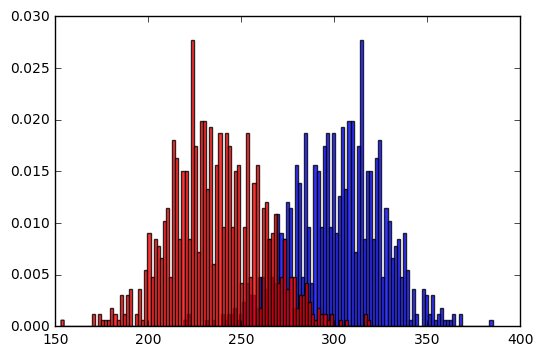

In [11]:
# Plot to show the distribution of total electoral college votes in the simulations

plt.hist(total_electoral_votes["clinton_ec"], color="blue", normed=True, bins=100, alpha=0.8)
plt.hist(total_electoral_votes["trump_ec"], color="red", normed=True, bins=100, alpha=0.8)
plt.show()

Bonus! You can visualise the results on a map in python. Maps tend to be pretty awkward in python which is why we tend to use Tableau, but I've done most of it for you here so you can focus on the fun. There is a topo-JSON file in the repo you can read in to map US states. You just need to `conda install vincent` in your terminal.

In [12]:
# Just going to visualise one simulation picked at random

state_data=results_total2.loc[results_total2["simulation_number"]==0,:]
state_data=state_data[["state", "winner"]]
mapping={"Clinton":1, "Trump":0}
state_data["winner"]=state_data["winner"].map(mapping)

In [13]:
# This is a library which can do some mapping quite nicely, though
# it doesn't seem to be well maintained and doesn't have particularly good documentation
# conda install vincent to get it

import vincent
vincent.initialize_notebook()

We read in a local file we have on US states and we set the map up to read the winner column against the
state name (which it can understand directly). I set the color scheme up to show Red and Blue.
It's interesting that so many states can be red and still the blues win, that's down to the electoral colleges.
Try seeing what you can map, eg the most common scenarios or some kind of average and perhaps you can show gradients
of colours depending on how likely a state is to be won by a party. This way you can highlight swing states like Florida and in the end you can make your most likely prediction and see what the results are. 

So your output should be:
- an overall victor
- a number of electoral college votes
- a set of states with victors for each state

Organised as you like: just a prediction (i.e. most likely outcome), or a percentage likelihood, or some different scenarios. Point is just that you have those predictions to compare to the real results when they come out some time on Wednesday morning!

In [14]:
state_topo="us_states.topo.json"
geo_data = [{'name': 'states','url': state_topo,'feature': 'us_states.geo'}]

vis = vincent.Map(data=state_data, geo_data=geo_data, scale=1100, data_bind='winner', data_key='state', 
                  map_key={'states': 'properties.NAME'}, projection='albersUsa')
vis.scales['color'].type = 'threshold'
vis.scales['color'].domain=[0,1]
vis.rebind(column='winner', brew='RdBu')
vis.display()

In [ ]:
# Please make sure whatever you end up with for your model, you output your predictions to a csv before the results
# are announced! Then we can compare it to the real outcome! Also try saving your map(s) as an image!


In [ ]:
# Suggest you make copies of the code above into cells below that you then tweak, you can always then refer back to
# the original code above when thinking about how to adjust your model


# My attempt - an aftermath analysis

In [4]:
polling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12624 entries, 0 to 12623
Data columns (total 27 columns):
cycle               12624 non-null int64
branch              12624 non-null object
type                12624 non-null object
matchup             12624 non-null object
forecastdate        12624 non-null object
state               12624 non-null object
startdate           12624 non-null object
enddate             12624 non-null object
pollster            12624 non-null object
grade               11337 non-null object
samplesize          12621 non-null float64
population          12624 non-null object
poll_wt             12624 non-null float64
rawpoll_clinton     12624 non-null float64
rawpoll_trump       12624 non-null float64
rawpoll_johnson     8397 non-null float64
rawpoll_mcmullin    90 non-null float64
adjpoll_clinton     12624 non-null float64
adjpoll_trump       12624 non-null float64
adjpoll_johnson     8397 non-null float64
adjpoll_mcmullin    90 non-null float64
multiver

### Explore Data

In [5]:
polling.cycle.value_counts()

2016    12624
Name: cycle, dtype: int64

In [6]:
polling.branch.value_counts()

President    12624
Name: branch, dtype: int64

From the above we know that the polling data is only for 2016 presidential election. Therefore these 2 columns can be dropped. The next 3 column are polling type, matchup and forecast_date which are not entirely useful hence will also be dropped. This is because it is difficult to comprehend or quantify polling types. Matchup is also unnecessary as we know that it would be either Trump or Hillary. forecast_date represents the election date so it is the same for every entry.

In [4]:
polling['startdate'] = pd.to_datetime(polling['startdate'])
polling['enddate'] = pd.to_datetime(polling['enddate'])
polling['forecastdate'] = pd.to_datetime(polling['forecastdate'])
polling['duration'] = polling['enddate'] - polling['startdate']
polling['days_before'] = polling['forecastdate'] - polling['enddate']

The data type of date entries are changed fron 'strings' to 'datetime'. A duration of the poll was then calculated by calculating the difference between the start date and end date. This could be important as the longer the poll is the more uncertain it would be. Therefore we will have to think about a strategy to reflect this truth.

Grading of the poll is also important as it directly reflects how good a poll was. There are some missing values hence they would have to be filled in. It is possible to fill those missing values with the most common value obtained by that particular pollster. There are 10 individual polling grades and they will be transformed into numbers for easier manipulation.

In [5]:
grade_dic = {'A+':1, 'A':2, 'A-':3, 'B+':4, 'B':5, 'B-':6, 'C+':7, 'C':8, 'C-':9, 'D':10}
polling['grade_numeric'] = polling['grade'].map(grade_dic)

In [6]:
polling['grade_numeric'] = polling['grade_numeric'].fillna(polling.groupby(['pollster'])['grade_numeric'].median())

However it seems that non-graded poll happens across entire organisations hence NaN values can not be filled this way. Other ways to fill in the missing values are experimented.

In [21]:
polling.groupby(['grade'])['samplesize'].mean()

grade
A      944.320755
A+     732.904762
A-     759.158525
B      973.647873
B+     896.382353
B-    1263.183099
C      717.448276
C+     971.542683
C-    1870.363636
D     1096.928571
Name: samplesize, dtype: float64

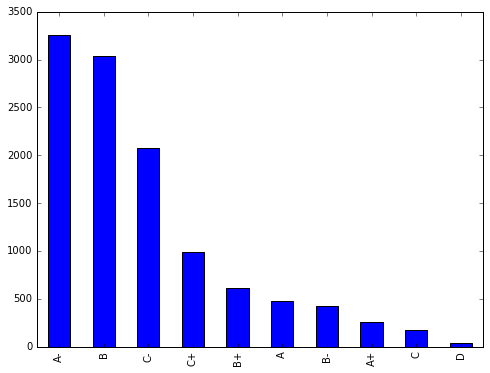

In [24]:
polling['grade'].value_counts().plot(kind='bar', figsize=(8,6))
plt.show()

We know that the median value should lie at about 6300th data point. By observing the plot above it can be concluded that if the polls are ranked (and in fact gradings are ordinal), the median would be a 'B'. Hence the missing values would be filled in such manner.

In [7]:
polling['grade_numeric'] = polling['grade_numeric'].fillna(5)

Some sample sizes are missing too. Further investigation would be carried out

In [26]:
polling[polling['samplesize'].isnull()]

cycle     branch        type                        matchup  \
1801    2016  President  polls-plus  Clinton vs. Trump vs. Johnson   
6023    2016  President    now-cast  Clinton vs. Trump vs. Johnson   
10217   2016  President  polls-only  Clinton vs. Trump vs. Johnson   

      forecastdate     state  startdate    enddate           pollster grade  \
1801       11/8/16  Illinois 2016-07-11 2016-07-12  Basswood Research    C+   
6023       11/8/16  Illinois 2016-07-11 2016-07-12  Basswood Research    C+   
10217      11/8/16  Illinois 2016-07-11 2016-07-12  Basswood Research    C+   

       samplesize population   poll_wt  rawpoll_clinton  rawpoll_trump  \
1801          NaN         lv  0.014828             46.4           32.5   
6023          NaN         lv  0.014828             46.4           32.5   
10217         NaN         lv  0.014828             46.4           32.5   

       rawpoll_johnson  rawpoll_mcmullin  adjpoll_clinton  adjpoll_trump  \
1801               5.2               NaN         49.62926       36.34003   
6023               5.2               NaN         49.63698       36.39108   
10217              5.2               NaN         49.63946       36.39749   

       adjpoll_johnson  adjpoll_mcmullin multiversions  \
1801          2.120584               NaN           NaN   
6023          2.212135               NaN           NaN   
10217         2.164237               NaN           NaN   

                                                     url  poll_id  \
1801   http://www.chicagobusiness.com/article/2016072...    44748   
6023   http://www.chicagobusiness.com/article/2016072...    44748   
10217  http://www.chicagobusiness.com/article/2016072...    44748   

       question_id createddate             timestamp  duration  grade_numeric  
1801         68432      8/2/16  09:35:33  8 Nov 2016    1 days            7.0  
6023         68432      8/2/16  09:24:53  8 Nov 2016    1 days            7.0  
10217        68432      8/2/16  09:14:14  8 Nov 2016    1 days            7.0

In [29]:
polling[polling['state'] ==  'Illinois'].shape

(180, 29)

It turns out this could be an organisational problem where it failed to report sample sizes. Considering Illinois has 180 polling record it would be OK to drop 3.

In [8]:
polling = polling[polling['samplesize'].notnull()]

Population and poll_wt are not easy to comprehend hence they will be dropped. Other irrelavent columns such as non-Trump/Hillary records will also be dropped.

In [11]:
polling_cleaned = polling[['state', 'enddate', 'samplesize', 'rawpoll_clinton', 'rawpoll_trump','duration', 'grade_numeric','days_before']]
polling_cleaned.head()

state    enddate  samplesize  rawpoll_clinton  rawpoll_trump  duration  \
0  U.S. 2016-11-06      2220.0            47.00          43.00    3 days   
1  U.S. 2016-11-07     26574.0            38.03          35.69    6 days   
2  U.S. 2016-11-06      2195.0            42.00          39.00    4 days   
3  U.S. 2016-11-07      3677.0            45.00          41.00    3 days   
4  U.S. 2016-11-06     16639.0            47.00          43.00    3 days   

   grade_numeric  days_before  
0            1.0       2 days  
1            5.0       1 days  
2            3.0       2 days  
3            5.0       1 days  
4            6.0       2 days

In [10]:
polling_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12621 entries, 0 to 12623
Data columns (total 8 columns):
state              12621 non-null object
enddate            12621 non-null datetime64[ns]
samplesize         12621 non-null float64
rawpoll_clinton    12621 non-null float64
rawpoll_trump      12621 non-null float64
duration           12621 non-null timedelta64[ns]
grade_numeric      12621 non-null float64
days_before        12621 non-null timedelta64[ns]
dtypes: datetime64[ns](1), float64(4), object(1), timedelta64[ns](2)
memory usage: 887.4+ KB


The intention of this study is to find out the voters' preference in each individual state hence the entries with U.S. in the state column will be dropped.

In [10]:
polling_state = polling_cleaned[polling_cleaned['state'] != 'U.S.']
polling_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9303 entries, 8 to 12623
Data columns (total 8 columns):
state              9303 non-null object
enddate            9303 non-null datetime64[ns]
samplesize         9303 non-null float64
rawpoll_clinton    9303 non-null float64
rawpoll_trump      9303 non-null float64
duration           9303 non-null timedelta64[ns]
grade_numeric      9303 non-null float64
days_before        9303 non-null timedelta64[ns]
dtypes: datetime64[ns](1), float64(4), object(1), timedelta64[ns](2)
memory usage: 654.1+ KB


In [12]:
# Convert timedeltas into floats denoting number of days

polling_state.loc[:,'duration'] = (polling_state['duration'].apply(lambda x:x.total_seconds())+86400)/86400

In [13]:
polling_state.loc[:,'days_before'] = polling_state['days_before'].apply(lambda x:x.total_seconds())/86400

In [14]:
polling_state.head()

state    enddate  samplesize  rawpoll_clinton  rawpoll_trump  \
8       New Mexico 2016-11-06      8439.0             46.0           44.0   
13        Virginia 2016-11-04      1238.0             48.0           43.0   
15            Iowa 2016-11-04       800.0             39.0           46.0   
17       Wisconsin 2016-10-31      1255.0             46.0           40.0   
18  North Carolina 2016-11-06       800.0             44.0           44.0   

    duration  grade_numeric  days_before  
8        1.0            5.0          2.0  
13       2.0            4.0          4.0  
15       4.0            1.0          4.0  
17       6.0            2.0          8.0  
18       3.0            2.0          2.0

### Visualisations

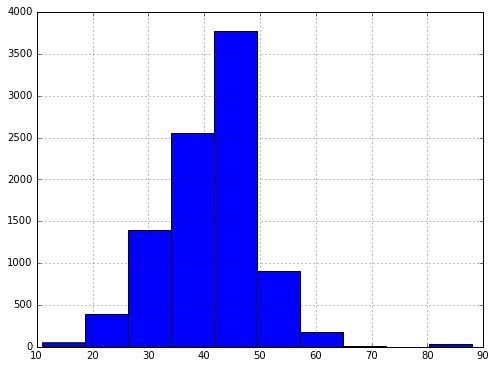

41.2764527572
8.6744192458


In [41]:
polling_state.rawpoll_clinton.hist(figsize=(8,6))
plt.show()
print polling_state.rawpoll_clinton.mean()
print polling_state.rawpoll_clinton.std()

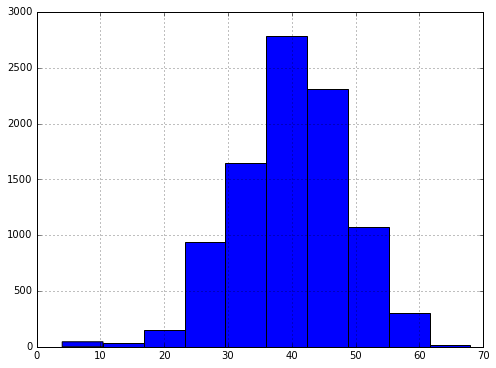

39.9001354402
8.7625313321


In [43]:
polling_state.rawpoll_trump.hist(figsize=(8,6))
plt.show()
print polling_state.rawpoll_trump.mean()
print polling_state.rawpoll_trump.std()

Without differentiating between states, histograms were plotted to see the distribution of voters preference. It can be seen that the the shape is nearly symmertric and the means lie at about high 30s to low 40s. With a standard deviation of 8 we immediately know that the distributions (assumed to be normal) are not significantly different. This reflects the common impression that Hillary is leading slightly but not by much.

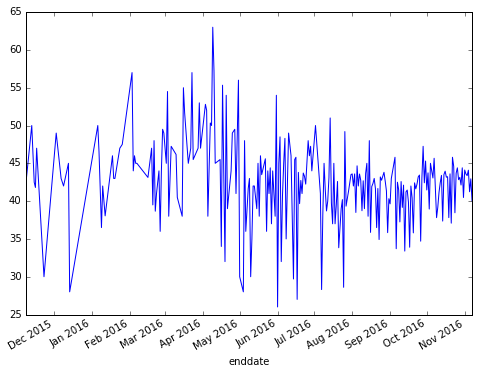

In [37]:
polling_state.groupby(['enddate'])['rawpoll_clinton'].mean().plot(figsize=(8,6))

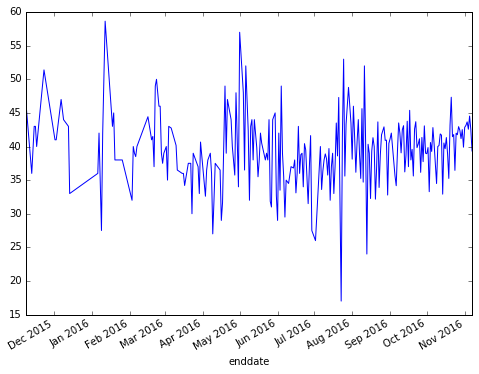

In [38]:
polling_state.groupby(['enddate'])['rawpoll_trump'].mean().plot(figsize=(8,6))

Again the above plots were created with all the states taken into consideration hence it is possible to observe the big variances within a short period of time. It can be seen that there were relatively few polls conducted in early 2016 and as the election approaches the frequency increased. It is also interesting to see that as time goes by the variance in voters opinion seem to decrease as more voters have set their minds on candidates. Without vigrous hypothesis testing, it seems that Trump's supporters increases in numbers towards the end of the election 

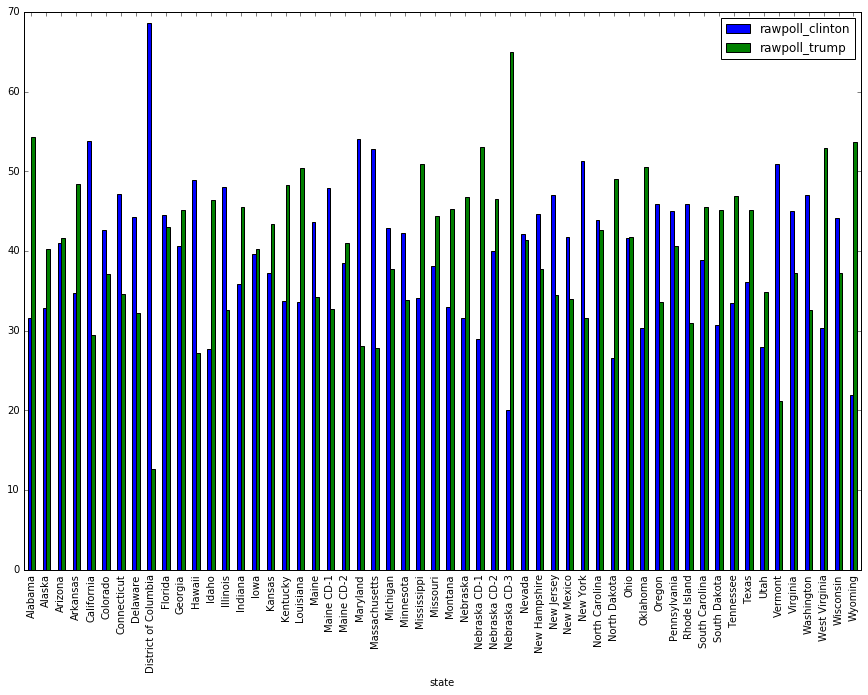

In [51]:
pd.pivot_table(polling_state, index=['state'], values=['rawpoll_clinton','rawpoll_trump']).plot(kind='bar',figsize=(15,10))

The plot above states the supporter distribution across the states. It is immediately obvious that Clinton is leading in District of Columbia whilst Trump is winning in Nebraska. However other than that there are no obvious clue of who is going to win the electon.

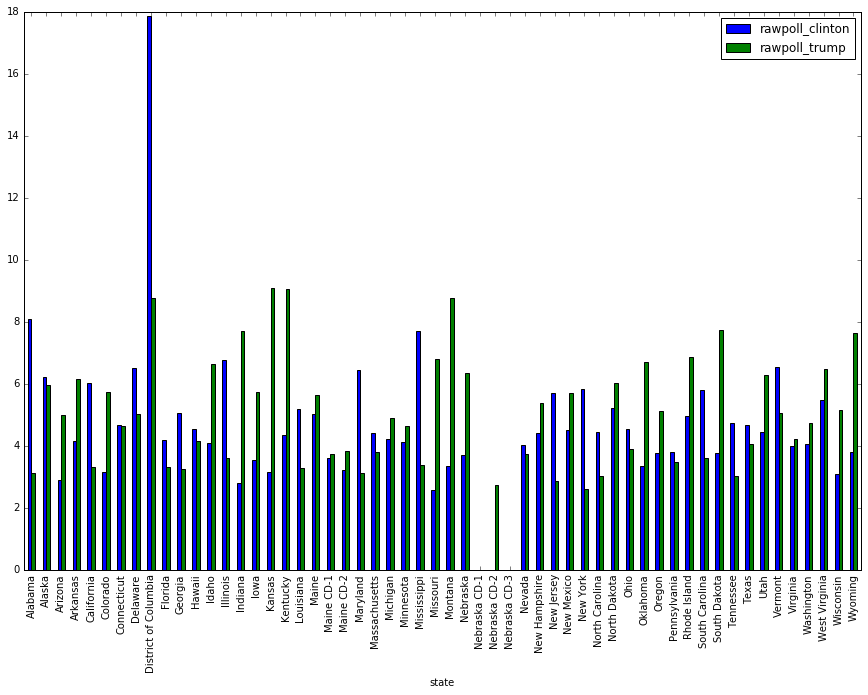

In [52]:
pd.pivot_table(polling_state, index=['state'], values=['rawpoll_clinton','rawpoll_trump'], aggfunc=np.std).plot(kind='bar',figsize=(15,10))

Looking deeper into the stadard deviation of data, it is realised that some data has no standard deviation. This could be due to the fact that through out the election campaign only 1 poll had been conducted. Hence this has to be noted if any further preprocessing is to be carried out. Comparing to the standard deviation calcualted earlier (without state differentiation), it seems that the within state standard deviation is much lower (under 8). It is possible to observe a spike on District of Columbia for Clinton though.

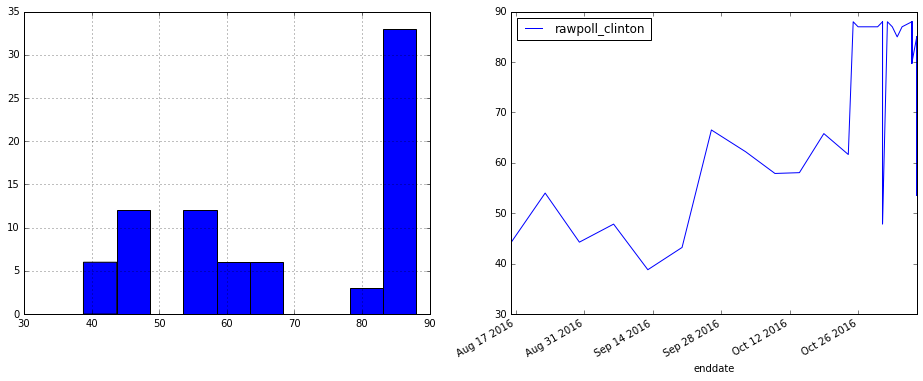

In [56]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
polling_state[polling_state['state']=='District of Columbia']['rawpoll_clinton'].hist(ax=ax1)
polling_state[polling_state['state']=='District of Columbia'].plot(x='enddate', y='rawpoll_clinton',ax=ax2)

The spike in standard deviation is mainly caused by a heavily skewed distribution favoring Clinton. When a distribution is heavily skewed, means and standard deviations would fail to serve as good descriptions. Another plot shows that the highly Clinton - favored polls took place towards the election which suggests there could be an increase of Clinton supporters in the state. However one should note that the variance was high as well and this would reduce the confidence of such concusion.

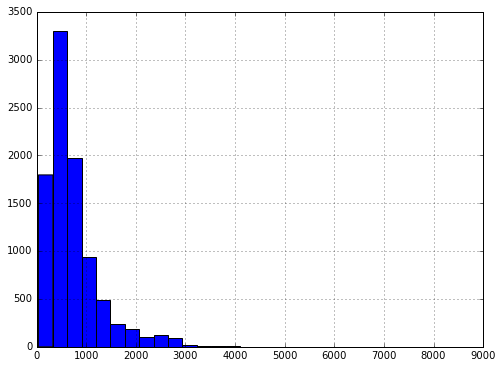

count    9303.000000
mean      735.622057
std       628.068884
min        35.000000
25%       387.000000
50%       594.000000
75%       887.000000
max      8746.000000
Name: samplesize, dtype: float64

In [28]:
polling_state.samplesize.hist(figsize=(8,6), bins=30)
plt.show()
polling_state.samplesize.describe()

The plot above shows that most polls have a sample size under 1000. However some polls conduct really big sample size of over 8000

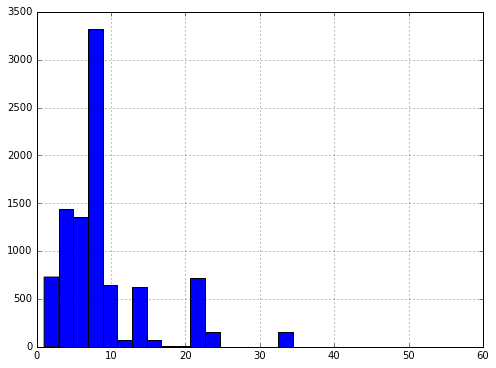

count    9303.000000
mean        8.384392
std         6.361548
min         1.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        60.000000
Name: duration, dtype: float64

In [29]:
polling_state.duration.hist(figsize=(8,6), bins=30)
plt.show()
polling_state.duration.describe()

Most polls lasted for less than 10 days.

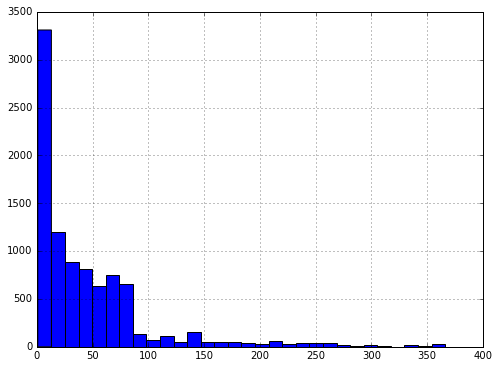

count    9303.000000
mean       46.157691
std        56.766152
min         1.000000
25%         8.000000
50%        26.000000
75%        63.000000
max       366.000000
Name: days_before, dtype: float64

In [30]:
polling_state.days_before.hist(figsize=(8,6), bins=30)
plt.show()
polling_state.days_before.describe()

Tha mjorith of the poll was conducted within 2 months before election time. The ones conducted earlier than that would deem less informative.

### Combining the poll data for each state

In order to perform the Monte Carlo simulation it is necessary to combine all the poll data into a single distribution. However not every poll are equal. This is being reflected by the polling grade, sample size, poll duration and the date that the poll ended. It can be safely assumed that the further away the poll is from the election date, the less informative it is. One solution around this problem is to assign the weights to the different polls. Inevitably this invloves many subjective judgement.

In [25]:
polling_state.head()

state    enddate  samplesize  rawpoll_clinton  rawpoll_trump  \
8       New Mexico 2016-11-06      8439.0             46.0           44.0   
13        Virginia 2016-11-04      1238.0             48.0           43.0   
15            Iowa 2016-11-04       800.0             39.0           46.0   
17       Wisconsin 2016-10-31      1255.0             46.0           40.0   
18  North Carolina 2016-11-06       800.0             44.0           44.0   

    duration  grade_numeric  days_before  
8        1.0            5.0          2.0  
13       2.0            4.0          4.0  
15       4.0            1.0          4.0  
17       6.0            2.0          8.0  
18       3.0            2.0          2.0

In [15]:
from sklearn.preprocessing import MinMaxScaler
def get_score(series):
    return MinMaxScaler(feature_range=(0.3,1)).fit_transform(series)

def sample_score(sample):
    if sample < 100:
        return 30 #The value of 30 is made up
    elif sample < 400:
        return 10
    elif sample < 1000:
        return 5
    elif sample < 10000:
        return 3
    else:
        return 1
# Information obtained from Wikipedia. (https://en.wikipedia.org/wiki/Sample_size_determination)

In [27]:
days_before_score = get_score(-1*polling_state['days_before']) # Multiply by -1 to reverse ranking
grade_score = get_score(-1*polling_state['grade_numeric'])
duration_score = get_score(-1*polling_state['duration'])
confidence = polling_state['samplesize'].apply(sample_score)

//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [35]:
polling_state['sample_score'] = get_score(-1*confidence)

//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [30]:
polling_state.head()

state    enddate  samplesize  rawpoll_clinton  rawpoll_trump  \
8       New Mexico 2016-11-06      8439.0         0.511111       0.488889   
13        Virginia 2016-11-04      1238.0         0.527473       0.472527   
15            Iowa 2016-11-04       800.0         0.458824       0.541176   
17       Wisconsin 2016-10-31      1255.0         0.534884       0.465116   
18  North Carolina 2016-11-06       800.0         0.500000       0.500000   

    duration  grade_numeric  days_before  sample_score  combined_weight  
8        1.0            5.0          2.0      0.300000         9.675792  
13       2.0            4.0          4.0      0.300000         8.227555  
15       4.0            1.0          4.0      0.351852         9.031569  
17       6.0            2.0          8.0      0.300000         8.783404  
18       3.0            2.0          2.0      0.351852         8.743829

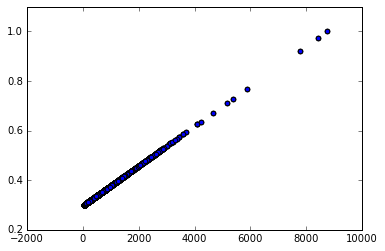

In [23]:
plt.scatter(x='samplesize', y='sample_score', data=polling_state) # Quick sanity check to see whether transformation
# is carried out properly

In [144]:
weight = {'days_before':500,
          'grade':0,
          'duration':0,
          'sample':0}
# Weighting system made up too.

In [145]:
polling_state['combined_weight'] = (days_before_score**2 + 
                                   grade_score*weight['grade'] +
                                   duration_score*weight['duration'] +
                                   polling_state['sample_score']*weight['sample'])

In [146]:
polling_state.combined_weight.describe()

count    9303.000000
mean        0.846143
std         0.170350
min         0.090000
25%         0.776330
50%         0.906408
75%         0.973331
max         1.000000
Name: combined_weight, dtype: float64

In [147]:
total_point = polling_state['rawpoll_clinton'] + polling_state['rawpoll_trump']
polling_state['rawpoll_clinton'] = polling_state['rawpoll_clinton']/total_point
polling_state['rawpoll_trump'] = polling_state['rawpoll_trump']/total_point
# Make sure sum of columns add to 1

In [148]:
polling_state.head()

state    enddate  samplesize  rawpoll_clinton  rawpoll_trump  \
8       New Mexico 2016-11-06      8439.0         0.511111       0.488889   
13        Virginia 2016-11-04      1238.0         0.527473       0.472527   
15            Iowa 2016-11-04       800.0         0.458824       0.541176   
17       Wisconsin 2016-10-31      1255.0         0.534884       0.465116   
18  North Carolina 2016-11-06       800.0         0.500000       0.500000   

    duration  grade_numeric  days_before  sample_score  combined_weight  
8        1.0            5.0          2.0      1.000000         0.996168  
13       2.0            4.0          4.0      1.000000         0.988526  
15       4.0            1.0          4.0      0.948148         0.988526  
17       6.0            2.0          8.0      1.000000         0.973331  
18       3.0            2.0          2.0      0.948148         0.996168

In [39]:
state = polling_state['state'].unique()

In [149]:
# Calculate the mean and standard deviation for each state.
from __future__ import division
state_dict = {}
for s in state:
    df = polling_state[polling_state['state']==s]
    weight = df['combined_weight']/sum(df['combined_weight'])
    clinton_mean = np.average(df['rawpoll_clinton'], weights=weight)
    trump_mean = np.average(df['rawpoll_trump'], weights=weight)
    m = df.shape[0]
    clinton_std = np.sqrt(sum(weight*(df['rawpoll_clinton']-clinton_mean)**2)/(sum(weight)-(sum(weight**2)/sum(weight))))
    trump_std = np.sqrt(sum(weight*(df['rawpoll_trump']-trump_mean)**2)/(sum(weight)-(sum(weight**2)/sum(weight))))
    state_dict[s] = {'clinton_mean':clinton_mean,
                     'clinton_std' : clinton_std,
                     'trump_mean' : trump_mean,
                     'trump_std' : trump_std}
    

In [139]:
state_dict

{'Alabama': {'clinton_mean': 0.36397681363362377,
  'clinton_std': 0.069740801995023846,
  'trump_mean': 0.63602318636637623,
  'trump_std': 0.069740801995023846},
 'Alaska': {'clinton_mean': 0.44797157605549165,
  'clinton_std': 0.057433802814106739,
  'trump_mean': 0.55202842394450824,
  'trump_std': 0.057433802814106726},
 'Arizona': {'clinton_mean': 0.49749374056345019,
  'clinton_std': 0.026397090610297921,
  'trump_mean': 0.50250625943654992,
  'trump_std': 0.026397090610297918},
 'Arkansas': {'clinton_mean': 0.41770553019321838,
  'clinton_std': 0.039550243931347581,
  'trump_mean': 0.58229446980678168,
  'trump_std': 0.039550243931347581},
 'California': {'clinton_mean': 0.64584795682423279,
  'clinton_std': 0.037111324043423793,
  'trump_mean': 0.35415204317576737,
  'trump_std': 0.037111324043423786},
 'Colorado': {'clinton_mean': 0.53665764360115487,
  'clinton_std': 0.038391926688550619,
  'trump_mean': 0.46334235639884508,
  'trump_std': 0.038391926688550619},
 'Connecticu

### Perform 5000 round Monte-Carlo simulation on election result. Code was give in lesson

In [150]:
# Perform a Monte Carlo simulation for eg 1000 elections in each state, where I have set a normal distribution
# on the polling numbers (which are in percentages) with a mean of the poll results and a 
# fixed standard deviation on every poll (so a number I just made up - you will want to look more 
# into this to see if you can vary it by state, perhaps based on an historical analysis of polls in the dataset)

random_seeds=uniform.rvs(loc=0, scale=5000, size=10000, random_state=42).astype(int)
results_total=pd.DataFrame(columns=["simulation_number","clinton_results", "trump_results", "state"])
i=0
for s in state_dict:
    # Simulate Clinton
    domain = state_dict[s]
    results_clinton=norm.rvs(domain['clinton_mean'], domain['clinton_std'], 5000, random_state=random_seeds[i])
    results_clinton_df=pd.DataFrame(results_clinton).reset_index()
    results_clinton_df.columns=["simulation_number", "clinton_results"]
    # Simulate Trump
    results_trump=norm.rvs(domain['trump_mean'], domain['trump_std'], 5000, random_state=random_seeds[i+1])    
    results_trump_df=pd.DataFrame(results_trump).reset_index()
    results_trump_df.columns=["simulation_number", "trump_results"]
    # Put them together
    results_both=pd.merge(results_clinton_df, results_trump_df, on="simulation_number")
    results_both["state"]= s
    results_total=pd.concat([results_total, results_both], ignore_index=True)
    i=i+1

In [151]:
# This calculates who won which state under the simulations, and then how many electoral college votes
# that implies will go to the winner for that particular simulation

results_total["winner"]=np.nan
results_total["winner"]=np.where(results_total["clinton_results"]>results_total["trump_results"], "Clinton", "Trump")
results_total2=pd.merge(results_total, electoral_college, on="state", how="left")
results_total2["trump_ec"]=np.where(results_total2["winner"]=="Trump", results_total2["electoral_votes"], 0)
results_total2["clinton_ec"]=np.where(results_total2["winner"]=="Clinton", results_total2["electoral_votes"], 0)

In [152]:
# Calculates how many electoral college votes each candidate wins for each of the simulations

trump_electoral_votes=results_total2.groupby(["simulation_number"])["trump_ec"].sum().reset_index()
clinton_electoral_votes=results_total2.groupby(["simulation_number"])["clinton_ec"].sum().reset_index()
total_electoral_votes=pd.merge(trump_electoral_votes, clinton_electoral_votes, on="simulation_number")

In [68]:
# Returns the percentage probability for each candidate to win based on how many of the simulations they won
# Weight 4,3,3,1
total_electoral_votes["winner"]=np.where(total_electoral_votes["clinton_ec"]>total_electoral_votes["trump_ec"], "Clinton", "Trump")
total_electoral_votes["winner"].value_counts(normalize=True)

Clinton    0.9978
Trump      0.0022
Name: winner, dtype: float64

In [153]:
# Returns the percentage probability for each candidate to win based on how many of the simulations they won
# Different weights
total_electoral_votes["winner"]=np.where(total_electoral_votes["clinton_ec"]>total_electoral_votes["trump_ec"], "Clinton", "Trump")
total_electoral_votes["winner"].value_counts(normalize=True)

Clinton    0.997
Trump      0.003
Name: winner, dtype: float64

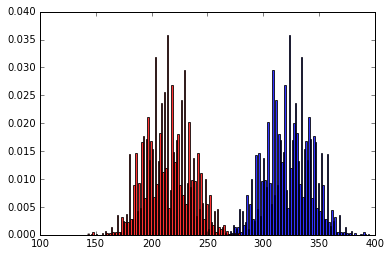

In [134]:
# Plot to show the distribution of total electoral college votes in the simulations

plt.hist(total_electoral_votes["clinton_ec"], color="blue", normed=True, bins=100, alpha=0.8)
plt.hist(total_electoral_votes["trump_ec"], color="red", normed=True, bins=100, alpha=0.8)
plt.show()

### Small Conclusion

Comparing to the reuslts generated by the instructor (who only looked at the most current poll), it seems that the accuracy of this simulation is even worse. It suggests that Clinton would almost certainly win but it is not the case in the real world (Or it might be that remaining 0.2%?). This has led one to think deeper about election analysis and predictions. For example this result seems to suggest that in elections, the more recent the poll the more relevant it is. This is because the above analysis consist of an aggreation of past results which some dates back to almost one year before the election. It is possible to try changing the weight to counter this effect but it does not yield significant improvement in this case. 

The simulation would also benefit from being provided more data. More data means more instances and greater variety. It is expected that Clinton would win out in this investigation because we are just recreating the distribution with the given data. It is <a href='http://www.independent.co.uk/news/world/americas/us-elections/mogia-ai-system-that-correctly-predicted-last-3-us-elections-says-donald-trump-will-win-artificial-a7384671.html'>reported</a> that some succeeded in predicting Trump's victory. However their approach was vastly different from the traditional method like the ones we have carried out. They have incorprated social media engagement as their main predictor. This is a very interesting obseravation as it has demonstrated online precense is very iportant even traditional sectors such as politics.

It is also a good reflection on the importance of data quality. In computer science there is a famous quote "Garbage in, garbage out". This is not to say that the data provided are not of good quality. It is only a fact that poll data quality can vary by a large amount. It is because we are assuming interviees are always speaking of the truth and the sample data are truely collected randomly. Neither of the factors are within the analyst control. This can also partly explain why so many analyst got the result wrong in the very first place.